In [1]:
# 標準ライブラリ
import gc
import os
import pickle
import random
import sys
import warnings
from itertools import combinations, permutations
from pathlib import Path
import pytz

# サードパーティのライブラリ
import category_encoders as ce
import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
import polars as pl
import scipy as sp
import seaborn as sns
import torch
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from dateutil.relativedelta import relativedelta
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, log_loss, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import (GroupKFold, KFold, StratifiedKFold,
                                     StratifiedGroupKFold, TimeSeriesSplit,
                                     train_test_split)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

import glob
import datetime

In [2]:
class CFG:
    home_directory = os.path.expanduser('~/kaggle_HomeCredit/')
    kaggle_directory = os.path.expanduser('/kaggle/input/home-credit-credit-risk-model-stability/')
    
    train_data_path = os.path.join(home_directory, 'train/')
    test_data_path = os.path.join(home_directory, 'test/')
    
    OOF_DATA_PATH = Path(home_directory) / 'oof'
    MODEL_DATA_PATH = Path(home_directory) / 'models'
    SUB_DATA_PATH = Path(home_directory) / 'submission'

    def __init__(self):
        self.create_directories()
    
    def create_directories(self):
        for path in [self.OOF_DATA_PATH, self.MODEL_DATA_PATH, self.SUB_DATA_PATH]:
            path.mkdir(parents=True, exist_ok=True)
    
    
    VER = 'EDA'
    AUTHOR = 'Mira'
    COMPETITION = 'HomeCredit'

    METHOD_LIST = ['lightgbm','catboost']
    seed = 28
    n_folds = 5
    target_col = 'target'
    metric = 'auc'
    
    metric_maximize_flag = True
    num_boost_round = 500
    early_stopping_round = 200
    verbose = 25
    classification_lgb_params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'seed': seed,
        #"device_type": "gpu",
    }
    classification_xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.05,
        'random_state': seed,
        "tree_method": "gpu_hist",
    }

    classification_cat_params = {
        'learning_rate': 0.05,
        'iterations': num_boost_round,
        'random_seed': seed,
        #"task_type": "GPU",
    }
    model_weight_dict = {'lightgbm': 0.5,'catboost':0.5}
    

class is_kaggle:
    def __init__(self, Kaggle):
        if Kaggle == "Yes":
            self.path = Path(CFG.kaggle_directory)
            CFG.MODEL_DATA_PATH = Path('/kaggle/input/04191103/models')
        else:
            self.path = Path(CFG.home_directory)
            CFG.MODEL_DATA_PATH = Path(CFG.home_directory) / 'models'

def create_timestamped_file():
    tz_tokyo = pytz.timezone('Asia/Tokyo')
    now = datetime.datetime.now(tz=tz_tokyo)
    filename = now.strftime('%m%d-%H%M') + '.txt'
    full_path = CFG.MODEL_DATA_PATH / filename
    full_path.touch()

#create_timestamped_file()
cfg_instance = CFG()      
selector = is_kaggle("No")

In [3]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [4]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_std = [pl.std(col).alias(f"std_{col}") for col in cols] 

        return expr_max + expr_min + expr_mean + expr_std 

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_min + expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [5]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob.glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    return df

In [6]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [7]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()

    # bool型の列をint型に変換
    bool_cols = df_data.select_dtypes('bool').columns
    df_data[bool_cols] = df_data[bool_cols].astype(int)

    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols


In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
ROOT = selector.path
TRAIN_DIR       = ROOT / "parquet_files/train"
TEST_DIR        = ROOT / "parquet_files/test"
SAMPLE_SUB = ROOT / "sample_submission.csv"

In [10]:
train_data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [11]:
test_data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [12]:
class DataPreprocessor:
    def __init__(self, df):
        self.df = df

    def select_numerical_columns(self):
        return self.df.select_dtypes(exclude='category').columns

    def calculate_nan_groups(self, nums):
        nans_df = self.df[nums].isna()
        nans_groups = {}
        for col in nums:
            cur_group = nans_df[col].sum()
            nans_groups.setdefault(cur_group, []).append(col)
        del nans_df
        gc.collect()
        return nans_groups

    def reduce_group(self, groups):
        use = []
        for group in groups:
            max_unique = 0
            selected_col = group[0]
            for col in group:
                unique_count = self.df[col].nunique()
                if unique_count > max_unique:
                    max_unique = unique_count
                    selected_col = col
            use.append(selected_col)
        print('Use these:', use)
        return use

    def group_columns_by_correlation(self, matrix, threshold=0.8):
        correlation_matrix = matrix.corr()
        cols = list(matrix.columns)
        groups = []

        while cols:
            base_col = cols.pop(0)
            group = [base_col]
            correlated_cols = [base_col]

            for col in cols:
                if correlation_matrix.loc[base_col, col] >= threshold:
                    group.append(col)
                    correlated_cols.append(col)

            groups.append(group)
            cols = [c for c in cols if c not in correlated_cols]

        return groups

    def plot_time_variation(self, column, title):
        """ Plot the variation of a numeric feature over 'weeks' """
        plt.figure(figsize=(10, 6))
        self.df.groupby('WEEK_NUM')[column].mean().plot()
        plt.title(title)
        plt.xlabel('Weeks')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()

    def update_dataframe(self):
        uses = self.process_columns()
        uses += list(self.df.select_dtypes(include='category').columns)
        print('Total columns used:', len(uses))
        self.df = self.df[uses]

    def process_and_plot(self):
        nums = self.select_numerical_columns()
        nans_groups = self.calculate_nan_groups(nums)

        for count, columns in nans_groups.items():
            if len(columns) > 1:
                grps = self.group_columns_by_correlation(self.df[columns])
                uses = self.reduce_group(grps)
            else:
                uses = columns

            for col in uses:
                if 'WEEK_NUM' in self.df.columns and self.df[col].dtype in [float, int]:
                    self.plot_time_variation(col, f"Variation of {col} over Weeks (NaN count = {count})")
            print('####### NAN count =', count)

In [13]:
df_train = feature_eng(**train_data_store)
print("train data shape:\t", df_train.shape)
del train_data_store
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)

df_test = feature_eng(**test_data_store)
print("test data shape:\t", df_test.shape)
del test_data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

"""
preprocessor = DataPreprocessor(df_train)
preprocessor.process_and_plot()
"""

train data shape:	 (1526659, 738)
Memory usage of dataframe is 4858.50 MB
Memory usage after optimization is: 1967.01 MB
Decreased by 59.5%
train data shape:	 (1526659, 519)
test data shape:	 (10, 737)
train data shape:	 (1526659, 519)
test data shape:	 (10, 518)
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.03 MB
Decreased by 27.8%


'\npreprocessor = DataPreprocessor(df_train)\npreprocessor.process_and_plot()\n'

In [14]:
df_train.groupby('WEEK_NUM')[CFG.target_col].value_counts()

WEEK_NUM  target
0         0         16335
          1           400
1         0         18369
          1           472
2         0         17011
                    ...  
89        1           309
90        0         11773
          1           330
91        0         12386
          1           288
Name: target, Length: 184, dtype: int64

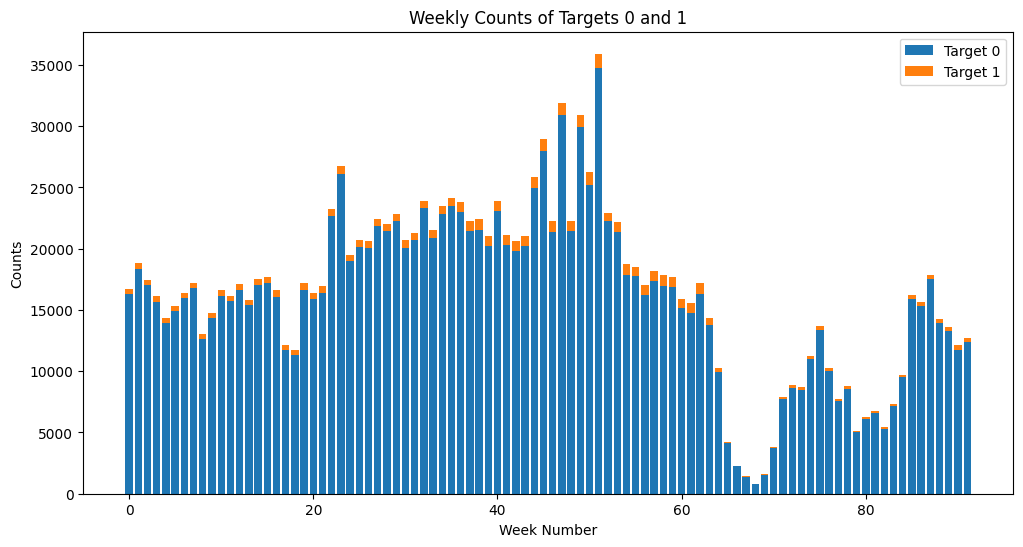

In [15]:
df = df_train.groupby('WEEK_NUM')[CFG.target_col].value_counts().reset_index(name='counts')
# ターゲットが0と1でデータを分割
df_0 = df[df['target'] == 0]
df_1 = df[df['target'] == 1]

# プロットの作成
plt.figure(figsize=(12, 6))
plt.bar(df_0['WEEK_NUM'], df_0['counts'], label='Target 0')
plt.bar(df_1['WEEK_NUM'], df_1['counts'], bottom=df_0['counts'], label='Target 1')

plt.xlabel('Week Number')
plt.ylabel('Counts')
plt.title('Weekly Counts of Targets 0 and 1')
plt.legend()
plt.show()

In [21]:
df.sort_values('counts')

,WEEK_NUM,target,counts
137,68,1,21
135,67,1,30
139,69,1,35
133,66,1,52
141,70,1,82
...,...,...,...
46,23,0,26101
90,45,0,27946
98,49,0,29924
94,47,0,30952
